# Simple GAN for Generating shirt designs

In [19]:
import h5py
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image


class Data:
    def __init__(self):
        with h5py.File("cell_data.h5", "r") as data:
            self.train_images = [data["/train_image_{}".format(i)][:] for i in range(28)]
            self.train_labels = [data["/train_label_{}".format(i)][:] for i in range(28)]
            self.test_images = [data["/test_image_{}".format(i)][:] for i in range(3)]
            self.test_labels = [data["/test_label_{}".format(i)][:] for i in range(3)]

        self.input_resolution = 300
        self.label_resolution = 116

        self.offset = (300 - 116) // 2
        

    def get_train_image_list_and_label_list(self):
        n = random.randint(0, len(self.train_images) - 1)
        x = random.randint(0, (self.train_images[n].shape)[1] - self.input_resolution - 1)
        y = random.randint(0, (self.train_images[n].shape)[0] - self.input_resolution - 1)
        image = self.train_images[n][y:y + self.input_resolution, x:x + self.input_resolution, :]

        x += self.offset
        y += self.offset
        label = self.train_labels[n][y:y + self.label_resolution, x:x + self.label_resolution]

        return [image], [label]

    def get_test_image_list_and_label_list(self):
        coord_list = [[0,0], [0, 116], [0, 232], 
                  [116,0], [116, 116], [116, 232],
                  [219,0], [219, 116], [219, 232]]

        image_list = []
        label_list = []
    
        for image_id in range(3):
            for y, x in coord_list:
                image = self.test_images[image_id][y:y + self.input_resolution, x:x + self.input_resolution, :]
                image_list.append(image)
                x += self.offset
                y += self.offset
                label = self.test_labels[image_id][y:y + self.label_resolution, x:x + self.label_resolution]
                label_list.append(label)
    

        return image_list, label_list

In [56]:
redImage = np.zeros((300, 300, 3), dtype=np.uint8)
for x in range(300):
    for y in range(300):
        redImage[x, y] = [random.randint(0, 255), random.randint(1, 70), random.randint(1, 70)]
img = Image.fromarray(redImage, 'RGB')
img.show()

orangeImage = np.zeros((300, 300, 3), dtype=np.uint8)
for x in range(300):
    for y in range(300):
        orangeImage[x, y] = [random.randint(0, 255), random.randint(0, 150), random.randint(0, 50)]
img = Image.fromarray(orangeImage, 'RGB')
img.show()
trainData = [(redImage, [1, 0]), (orangeImage, [0, 1])]

In [3]:
def getRandomTrainImageAndLabel(data):
    test_image_and_label = data.get_train_image_list_and_label_list()
    randomInt = np.random.randint(0, len(test_image_and_label[0]))
    train_image = test_image_and_label[0][randomInt].reshape((1, 300, 300))
    train_label = test_image_and_label[1][randomInt]
    return train_image, train_label

def getRandomTestImageAndLabel(data):
    test_image_and_label = data.get_test_image_list_and_label_list()
    randomInt = np.random.randint(0, len(test_image_and_label[0]))
    test_image = test_image_and_label[0][randomInt].reshape((1, 300, 300))
    test_label = test_image_and_label[1][randomInt]
    return test_image, test_label 

In [4]:
# predefined functions to add noise to initial values of weights and biases
def weight_variable(shape):
    initial = tf.glorot_uniform_initializer()
    return tf.Variable(initial(shape))


def bias_variable(shape):
    initial = tf.zeros.initializer()
    return tf.Variable(initial(shape))

# predefined conv and pool layers with stride and padding set
def conv2d(x, W):
    return tf.nn.conv2d(x, filter=W, strides=[1, 1, 1, 1], padding='VALID')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


# predefined transposed convolution layer
def conv2d_transposed(x, filters): 
    return tf.layers.conv2d_transpose(inputs=x, filters=filters, 
                                      kernel_size=[2, 2], strides=[2, 2], padding='VALID')

In [5]:
def visualizeImage(image):
    """ Plots one image. Only works with square shaped images formatted as in the cell data file."""
    image = image.reshape((image.shape[1], image.shape[1]))
    size = len(image)
    label = image
    label_pixels = np.array(label).reshape((size, size))
    # plt.title('Original image')
    plt.imshow(label_pixels, cmap='gray')
    plt.show()

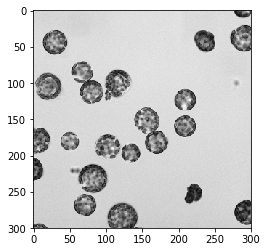

In [6]:
data = Data()
randomTrainImageAndLabel = getRandomTrainImageAndLabel(data)
visualizeImage(randomTrainImageAndLabel[0])

In [7]:
def Discriminator(input_images):
    """ An CNN that labels a skalar probability that an image is a real cell image. 
    300x300x1 -> 1x1x2 
    """
    
    with tf.name_scope('reshaping'):
        x_reshaped = tf.reshape(input_images, [-1, 300, 300, 1])

    
    # convolutional layer, result shape: 298x298, 32 filters --------------------------------------
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([3, 3, 1, 32])
        h_conv1 = tf.nn.relu(conv2d(x_reshaped, W_conv1))
        
        
    # convolutional layer, result shape: 296x296, 32 filters
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([3, 3, 32, 32])
        h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2))


    # max pool layer, result shape: 148x148, 32 filters
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv2)
    
    
    # convolutional layer, result shape: 146x146, 64 filters --------------------------------------
    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([3, 3, 32, 64])
        h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv3))
        
        
    # convolutional layer, result shape: 144x144, 64 filters
    with tf.name_scope('conv4'):
        W_conv4 = weight_variable([3, 3, 64, 64])
        h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4))


    # max pool layer, result shape: 72x72, 64 filters
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv4)
    
    
    # convolutional layer, result shape: 70x70, 128 filters --------------------------------------
    with tf.name_scope('conv5'):
        W_conv5 = weight_variable([3, 3, 64, 128])
        h_conv5 = tf.nn.relu(conv2d(h_pool2, W_conv5))
        
        
    # convolutional layer, result shape: 68x68, 128 filters
    with tf.name_scope('conv6'):
        W_conv6 = weight_variable([3, 3, 128, 128])
        h_conv6 = tf.nn.relu(conv2d(h_conv5, W_conv6))


    # max pool layer, result shape: 34x34, 128 filters
    with tf.name_scope('pool3'):
        h_pool3 = max_pool_2x2(h_conv6)
    
    
    # convolutional layer, result shape: 32x32, 256 filters --------------------------------------
    with tf.name_scope('conv7'):
        W_conv7 = weight_variable([3, 3, 128, 256])
        h_conv7 = tf.nn.relu(conv2d(h_pool3, W_conv7))
        
        
    # convolutional layer, result shape: 30x30, 256 filters
    with tf.name_scope('conv8'):
        W_conv8 = weight_variable([3, 3, 256, 256])
        h_conv8 = tf.nn.relu(conv2d(h_conv7, W_conv8))


    # max pool layer, result shape: 15x15, 256 filters
    with tf.name_scope('pool4'):
        h_pool4 = max_pool_2x2(h_conv8)
    
    
    # convolutional layer, result shape: 13x13, 512 filters --------------------------------------     
    with tf.name_scope('conv9'):
        W_conv9 = weight_variable([3, 3, 256, 512])
        h_conv9 = tf.nn.relu(conv2d(h_pool4, W_conv9))
        
        
    # convolutional layer, result shape: 11x11, 512 filters
    with tf.name_scope('conv10'):
        W_conv10 = weight_variable([3, 3, 512, 512])
        h_conv10 = tf.nn.relu(conv2d(h_conv9, W_conv10))
        
        
    # max pool layer, result shape: 5x5, 512 filters
    with tf.name_scope('pool5'):
        h_pool5 = max_pool_2x2(h_conv10)
        
        
    # convolutional layer, result shape: 3x3, 1024 filters --------------------------------------     
    with tf.name_scope('conv11'):
        W_conv11 = weight_variable([3, 3, 512, 1024])
        h_conv11 = tf.nn.relu(conv2d(h_pool5, W_conv11))
        
        
    # convolutional layer, result shape: 1x1, 1024 filters
    with tf.name_scope('conv12'):
        W_conv12 = weight_variable([3, 3, 1024, 1024])
        h_conv12 = tf.nn.relu(conv2d(h_conv11, W_conv12))
        
        
    # flatten to be able to fully connect
    with tf.name_scope('flatten'):    
        h_conv12_flat = tf.reshape(h_conv12, [-1, 1 * 1 * 1024])
    
    # fc layer, result shape: 1x1, 256 filters
    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([1024, 256])
        b_fc1 = bias_variable([256])
        y_fc1 = tf.matmul(h_conv12_flat, W_fc1) + b_fc1
        
        
    # fc layer, result shape: 1x1, 2 filters
    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([256, 2])
        b_fc2 = bias_variable([2])
        y_fc2 = tf.matmul(y_fc1, W_fc2) + b_fc2
    
    
    return y_fc2

In [8]:
def trainAndTestNet(epochs, restore=False):
    # Placeholder for input
    x = tf.placeholder(tf.float32, [None, 300, 300])
    
    # Placeholder for label 
    labels = tf.constant([1, 1, 0], dtype=tf.float32)
    
    # Placeholder for output
    y = Discriminator(x)
    # TODO delete
    y_flat = tf.reshape(y, [-1, -1, 2])
    
    # Calculate loss from original image
    with tf.name_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=y_flat)
        loss = tf.reduce_mean(cross_entropy)
        
    tf.summary.scalar('loss', loss)
    
    # optimize loss with the AdamOptimizer
    with tf.name_scope("AdamOptimizer"):
        train_step = tf.train.AdamOptimizer(0.0001, 0.95, 0.99).minimize(loss)
        
        
    merged_summary_op = tf.summary.merge_all()
    
    with tf.Session() as sess:
        saver = tf.train.Saver()
        if not restore:
            sess.run(tf.global_variables_initializer())
            writer = tf.summary.FileWriter('C:/Users/Kai/', graph=sess.graph)
            for epoch in range(epochs):
                    train_image, train_label = getRandomTrainImageAndLabel(data)

                    if epoch % 1000 == 0:
    
                        # evaluate loss for the testing data
                        train_loss = loss.eval(feed_dict={x: train_image})
                        
                        print('step %d, training loss %0.3f' % (epoch, train_loss))
                    
                    train_step.run(feed_dict={x: train_image})

                    # collect data for summary
                    summary_str = sess.run(merged_summary_op, feed_dict={x: train_image, labels: train_label})
                    writer.add_summary(summary_str, epoch)
            save_path = saver.save(sess, "C:/Users/Kai/" + str(epochs) + "/model.ckpt")
        else:
            saver.restore(sess, "C:Users/Kai/DeepLearningLab/Project4/model/20000/model.ckpt")

In [9]:
trainAndTestNet(40000, restore=False)

AttributeError: 'function' object has no attribute 'initializer'